You can find the dataset using the extracted features [here](https://www.kaggle.com/fleanend/birds-songs-numeric-dataset).

In [1]:
!pip install soundfile librosa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from librosa import core, onset, feature, display
import soundfile as sf
import umap
from IPython.display import Audio
import sklearn

In [3]:
df = pd.read_csv("../input/birdsong_metadata.csv")
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [4]:
def load_audio(file_id):
    data, samplerate = sf.read("../input/songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = feature.melspectrogram(data, sr=samplerate, hop_length=512)
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

In [5]:
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    #print(len(data[audio_mask])/sample_rate)

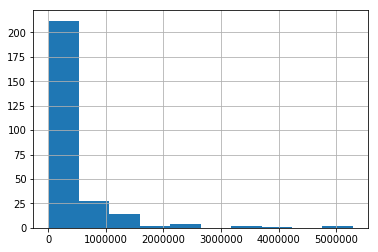

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [6]:
df['length'].hist()
plt.show()
df['length'].describe()

In [7]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15


In [8]:
# To relax the problem we'll consider the genus as the label instead of the species
# We use 23 windows per genus to have a balanced data set

n_windows = df.groupby('species')['windows'].sum().min()
n_windows

20

In [9]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        

In [10]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

In [11]:
# Extract Features from Window
new_dataset = pd.DataFrame()

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset.head()

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,...,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,genus,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,0.997944,0.832392,0.765386,0.704275,0.655724,0.331064,0.927524,0.307601,0.492226,0.167480,0.570316,0.384275,0.460739,0.405858,0.508725,0.377587,0.421529,0.555181,0.167464,0.229470,0.115128,0.863785,0.256774,0.204660,0.205049,0.236885,1.000000,1.0,0.768940,0.855763,1.0,0.281708,0.676977,0.246302,1.0,0.225182,0.421201,0.384887,0.459171,0.602492,...,0.097881,0.399511,0.434186,0.071515,0.224906,0.210857,0.211435,0.250697,0.424607,0.259147,1.0,1.0,0.066887,0.147749,0.262567,0.309703,0.158732,0.118034,0.075005,0.050695,0.455465,0.600963,0.254863,0.235006,0.235639,Acanthis,2439.940409,2618.082983,2585.327414,2624.325873,2507.041444,2730.515996,2609.940118,2703.391485,2676.400501,2818.375970,2706.119792,2740.820762,2684.624946,flammea
1,0.996255,0.839120,0.760417,0.705142,0.662990,0.329859,0.924461,0.300951,0.493679,0.167647,0.571775,0.378023,0.459869,0.388184,0.496655,0.366662,0.416597,0.555699,0.165287,0.223400,0.111835,0.846243,0.257517,0.203391,0.197892,0.231189,1.000000,1.0,0.757923,0.853638,1.0,0.279945,0.668103,0.240182,1.0,0.224796,0.418781,0.375944,0.455247,0.608755,...,0.100137,0.396697,0.429611,0.069987,0.229855,0.217518,0.217188,0.248268,0.417023,0.259224,1.0,1.0,0.063777,0.145189,0.265910,0.314990,0.158417,0.117571,0.074720,0.050129,0.450014,0.604398,0.255051,0.240605,0.242143,Acanthis,2447.419880,2622.258158,2585.928421,2620.109842,2490.339399,2730.212864,2609.668564,2703.721292,2676.695013,2818.554958,2705.497472,2741.509333,2683.727859,flammea
2,0.970810,0.823540,0.759508,0.709058,0.659750,0.336233,0.933035,0.301501,0.491263,0.168141,0.580005,0.370544,0.477255,0.398814,0.507451,0.374144,0.426826,0.565268,0.166964,0.229751,0.117323,0.866076,0.250993,0.208187,0.199218,0.244975,1.000000,1.0,0.762398,0.861123,1.0,0.284044,0.679951,0.245429,1.0,0.220376,0.430086,0.372526,0.475857,0.593367,...,0.100761,0.403566,0.430235,0.069762,0.225208,0.211704,0.210756,0.254208,0.423704,0.259299,1.0,1.0,0.066675,0.149646,0.265011,0.308419,0.158670,0.117275,0.074744,0.051321,0.465730,0.596814,0.251917,0.233473,0.237492,Acanthis,2437.991801,2620.895333,2587.440124,2619.813363,2497.486714,2729.438087,2609.010529,2704.515718,2677.465965,2818.971388,2703.952638,2743.213960,2681.482884,flammea
3,1.000000,0.855558,0.752038,0.710977,0.664579,0.334564,0.928026,0.292012,0.493557,0.168450,0.582334,0.361733,0.476070,0.383725,0.499559,0.358146,0.412545,0.540492,0.163766,0.220618,0.112485,0.840051,0.252426,0.206126,0.188957,0.236287,0.969370,1.0,0.746139,0.861499,1.0,0.281487,0.666361,0.236777,1.0,0.219803,0.426364,0.359748,0.469929,0.604584,...,0.106004,0.399199,0.423232,0.066849,0.232764,0.221859,0.219452,0.250252,0.412649,0.259777,1.0,1.0,0.061559,0.147295,0.270347,0.315871,0.155774,0.116662,0.074341,0.050472,0.457809,0.602008,0.252139,0.242191,0.247353,Acanthis,2

In [12]:
# Extract Features from Window for test
new_dataset_test = pd.DataFrame()

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test.head()

/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,chromogram_0_7,chromogram_0_8,chromogram_0_9,chromogram_10_0,chromogram_10_1,chromogram_10_10,chromogram_10_11,chromogram_10_12,chromogram_10_2,chromogram_10_3,chromogram_10_4,chromogram_10_5,chromogram_10_6,chromogram_10_7,chromogram_10_8,chromogram_10_9,chromogram_11_0,chromogram_11_1,chromogram_11_10,chromogram_11_11,chromogram_11_12,chromogram_11_2,chromogram_11_3,chromogram_11_4,chromogram_11_5,chromogram_11_6,chromogram_11_7,chromogram_11_8,chromogram_11_9,chromogram_1_0,...,chromogram_8_1,chromogram_8_10,chromogram_8_11,chromogram_8_12,chromogram_8_2,chromogram_8_3,chromogram_8_4,chromogram_8_5,chromogram_8_6,chromogram_8_7,chromogram_8_8,chromogram_8_9,chromogram_9_0,chromogram_9_1,chromogram_9_10,chromogram_9_11,chromogram_9_12,chromogram_9_2,chromogram_9_3,chromogram_9_4,chromogram_9_5,chromogram_9_6,chromogram_9_7,chromogram_9_8,chromogram_9_9,genus,spec_centr_0,spec_centr_1,spec_centr_10,spec_centr_11,spec_centr_12,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,0.550755,0.389564,0.407582,0.292242,0.438483,0.310931,0.360188,0.475396,0.153734,0.183664,0.086890,0.721472,0.291019,0.186642,0.169520,0.178003,0.870292,1.000000,0.707570,0.825455,1.000000,0.263299,0.601128,0.207320,1.000000,0.240204,0.367470,0.354299,0.385434,0.635905,...,0.112675,0.359274,0.400236,0.063872,0.271982,0.268593,0.272922,0.235675,0.370772,0.265330,1.000000,1.000000,0.046076,0.127977,0.287462,0.357491,0.136863,0.119350,0.076690,0.047758,0.381675,0.633082,0.265881,0.301352,0.302617,Acanthis,2442.401019,2614.190537,2582.947593,2620.439113,2486.230223,2731.690858,2611.073052,2702.003237,2675.278369,2817.586461,2708.632709,2738.029236,2688.206943,flammea
1,0.650246,0.590960,0.712450,0.909643,0.727013,0.502476,1.000000,0.242925,0.337245,0.167843,0.537517,0.335647,0.398841,0.851160,1.000000,0.689815,0.813982,1.000000,0.257333,0.584855,0.197694,1.000000,0.238709,0.353069,0.337249,0.372751,1.000000,0.969905,0.743664,0.720850,0.723751,0.307423,0.873910,0.271188,0.530654,0.170161,0.544333,0.381182,0.399810,0.354009,...,0.126077,0.297685,0.370665,0.131701,0.120063,0.077588,0.047634,0.374172,0.638933,0.266756,0.320606,0.324048,0.273122,0.425427,0.296418,0.344600,0.450420,0.150033,0.173547,0.081134,0.694420,0.298939,0.183440,0.158240,0.168126,Acanthis,2439.816039,2615.557171,2583.242814,2622.370901,2502.704268,2731.547262,2610.927073,2702.182796,2675.414148,2817.691756,2708.316600,2738.381425,2687.759668,flammea
2,1.000000,0.833207,0.770394,0.702116,0.655413,0.326867,0.922793,0.313101,0.493068,0.167065,0.562088,0.396560,0.447105,0.402712,0.506301,0.380523,0.419544,0.552228,0.167998,0.229231,0.113429,0.861854,0.261876,0.201714,0.210235,0.230222,0.997616,1.000000,0.774528,0.852260,1.000000,0.279948,0.674404,0.247360,1.000000,0.229525,0.413701,0.395900,0.445419,0.601185,...,0.094868,0.396181,0.437434,0.071695,0.224649,0.210234,0.212028,0.247980,0.425321,0.259218,1.000000,1.000000,0.066029,0.145302,0.260478,0.311302,0.159228,0.118703,0.075252,0.050205,0.446934,0.604469,0.257465,0.236373,0.234123,Acanthis,2448.524456,2617.983004,2583.538685,2624.183206,2503.140943,2731.402739,2610.782378,2702.360640,2675.551167,2817.795126,2708.001038,2738.732677,2687.312293,flammea
3,0.991786,0.829836,0.769562,0.702360,0.658253,0.327552,0.923582,0.312167,0.492926,0.167125,0.563454,0.394479,0.449345,0.400502,0.505318,0.380035,0.423235,0.564479,0.167902,0.229271,0.113701,0.862174,0.261017,0.202200,0.209358,0.231316,1.000000,1.000000,0.773598,0.851224,1.000000,0.280226,0.674835,0.247164,1.000000,0.228787,0.414943,0.394037,0.447676,0.605966,...,0.095271,0.396726,0.436763,0.071672,0.224692,0.210331,0.211928,0.248414,0.425206,0.259194,1.000000,1.000000,0.065760,0.145411,0.260826,

In [13]:
# Prepare dataset to fit a simple model

features= list(new_dataset.columns)
features.remove('species')
features.remove('genus')

X = new_dataset[features].values
y = new_dataset['species'].values

X_test = new_dataset_test[features].values
y_test = new_dataset_test['species'].values

In [14]:
# Use Naive Bayes as benchmark 

from sklearn import naive_bayes
NB = naive_bayes.GaussianNB()

SSS = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2)

accs = [] 

for train_index, val_index in SSS.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    NB.fit(X_train, y_train)
    
    y_pred = NB.predict(X_val)
    
    accs.append(sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_val))
    
print(accs)

[0.8892045454545454, 0.8948863636363636, 0.9375, 0.875, 0.9119318181818182]


In [15]:
y_pred = NB.predict(X_test)
sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)

0.8600986406832671

In [16]:
# The data can be used to predict, let's export the newly created datasets

new_dataset.to_csv("train.csv")
new_dataset_test.to_csv("test.csv")